COMP5329 – Deep Learning
Assignment 1
Team: 
-	vyun8699 - 530454874
-	gzha9095 – 500543568

Note on imports:
- You are NOT allowed to use Deep Learning frameworks (e.g. PyTorch, Tensorflow, Caffe, and KERAS), or any kinds of auto-grad tools (e.g. autograd).
- Scientific computing packages, such as NumPy and SciPy, are acceptable. 

Note on code sources:
- Week 3: activation function, hidden layers, MLP
- Week 4: momentum, AdaGrad, Adam, SGD
- Week 5: dropout, batch normalization

Code penalties:
- well organized, commented, documented [5]
- Badly written code [-20]
- Not including instructions on how to run code (ie. readme.txt) [-30]

In [6]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import time # to track model speeds

In [7]:
# Data loading
train_data = np.load('Assignment1-Dataset/train_data.npy')
train_label = np.load('Assignment1-Dataset/train_label.npy')
test_data = np.load('Assignment1-Dataset/test_data.npy')
test_label = np.load('Assignment1-Dataset/test_label.npy')

# set mean to 0 with standard deviation 1
train_mean = np.mean(train_data)
train_std = np.std(train_data)
adj_train_data = (train_data - train_mean) / train_std
adj_test_data = (test_data - train_mean) / train_std

random_state:42, input_data: (1600, 128), output_data: (1600, 1)


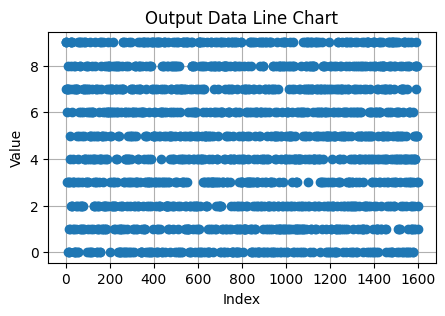

In [17]:
# data size scaler

def create_smaller_dataset(train_data, train_label, n, random_state = None):
    smaller_data = []
    smaller_label = []
    
    unique_labels = np.unique(train_label)
    rs_generator = np.random.RandomState(random_state)
    
    for label in unique_labels:
        label_indices = np.where(train_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(n*len(label_indices)), replace=False)
        
        smaller_data.extend(train_data[selected_indices])
        smaller_label.extend(train_label[selected_indices])
    
    smaller_data = np.array(smaller_data)
    smaller_label = np.array(smaller_label)

    #reshuffle data because for some reason everything is grouped by class again
    shuffled_indices = np.arange(len(smaller_data))
    rs_generator.shuffle(shuffled_indices)
    smaller_data = smaller_data[shuffled_indices]
    smaller_label = smaller_label[shuffled_indices]
    
    print(f'random_state:{random_state}, input_data: {smaller_data.shape}, output_data: {smaller_label.shape}')
    
    return smaller_data, smaller_label


#test
data_proportion = .2
random_state = 42
input_data, output_data = create_smaller_dataset(adj_train_data, train_label, data_proportion, random_state = random_state)
plt.figure(figsize=(5, 3))  # just big enough
plt.plot(output_data, marker='o', linestyle='')  # Plot the data with markers
plt.title('Output Data Line Chart')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.grid(True)  # Show grid lines (optional)
plt.show()  # Display the plot


length of train data: 8000, train label: 8000, head: [[4 1 5 5 9 1 6 8 1 6]]
length of val data: 2000, val label: 2000, head: [[4 5 3 2 2 7 5 8 1 7]]


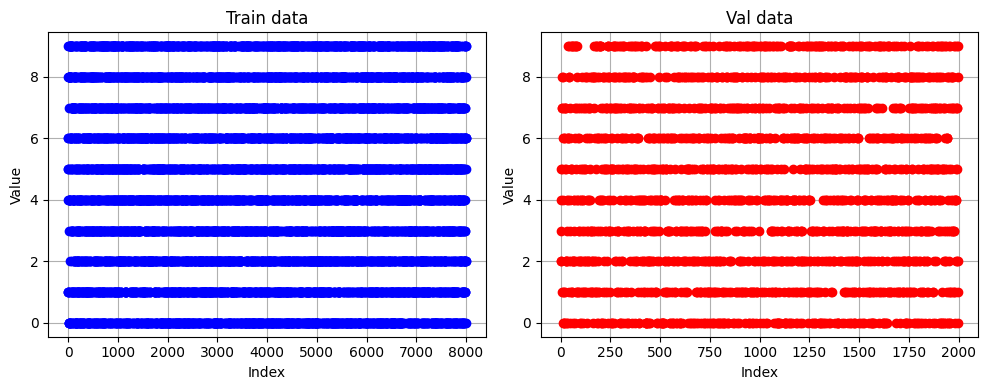

In [15]:
def train_val_split(train_data, train_label, train_proportion = 0.8, random_state = None):
    
    train_data_list, train_label_list = [],[]
    val_data_list, val_label_list = [],[]

    #use similar function as create_smaller_data
    unique_labels = np.unique(train_label)
    rs_generator = np.random.RandomState(random_state)

    for label in unique_labels:
        label_indices = np.where(train_label == label)[0]
        size = int(train_proportion * len(label_indices))
        selected_indices = rs_generator.choice(label_indices, size=size, replace=False)
        
        # populate lists (anything that doesn't go to train, goes to val)
        train_data_list.extend(train_data[selected_indices])
        train_label_list.extend(train_label[selected_indices])
        val_indices = np.setdiff1d(label_indices, selected_indices)
        val_data_list.extend(train_data[val_indices])
        val_label_list.extend(train_label[val_indices])

    #create arrays
    train_data = np.array(train_data_list)
    train_label = np.array(train_label_list)
    val_data = np.array(val_data_list)
    val_label = np.array(val_label_list)

    # shuffle train data (just in case it sorts again)
    train_shuffle_indices = np.arange(len(train_data))
    rs_generator.shuffle(train_shuffle_indices)
    train_data = train_data[train_shuffle_indices]
    train_label = train_label[train_shuffle_indices]
    
    # shuffle val data (just in case it sorts again)
    val_shuffle_indices = np.arange(len(val_data))
    rs_generator.shuffle(val_shuffle_indices)
    val_data = val_data[val_shuffle_indices]
    val_label = val_label[val_shuffle_indices]
    
    head_length = 10
    print(f'length of train data: {len(train_data)}, train label: {len(train_label)}, head: {train_label[0:head_length].T}')
    print(f'length of val data: {len(val_data)}, val label: {len(val_label)}, head: {val_label[0:head_length].T}')
    
    return train_data, train_label, val_data, val_label


#test

train_data, train_label, val_data, val_label =train_val_split(input_data, output_data, train_proportion = 0.8, random_state = 42)

# Set up the matplotlib figure and axes, one for each bar chart
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot for training data
axs[0].plot(train_label, marker='o', linestyle ='', color = 'blue')
axs[0].set_title('Train data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].grid(True)

# Plot for validation data
axs[1].plot(val_label, marker='o', linestyle ='', color = 'red')
axs[1].set_title('Val data')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [18]:
# plot function

def plot_results(input_data, output_data, batch_size, epoch_loss):
   
   #plot loss
   step = (len(input_data) / batch_size) 
   epoch_x_values = np.arange(step, (len(epoch_loss) + 1) * step, step)
   #batch_x_values = np.arange(len(batch_loss))
   
   
   plt.figure(figsize=(15,5))
   plt.title('Cross entropy loss')

   # Plot batch_loss as blue dots
   #plt.plot(batch_x_values, batch_loss, 'bo', label='Batch loss')  # Blue dots for batch loss

   # Plot epoch_loss as a red line
   plt.plot(epoch_x_values, epoch_loss, 'r-', label='Epoch loss')  # Red line for epoch loss

   plt.xlabel('Batches')
   plt.ylabel('Loss')
   plt.legend()
   plt.show()


   # plot prediction
   output_unique_values, output_counts = np.unique(output, return_counts=True)
   true_label_unique_values, true_label_counts = np.unique(output_data, return_counts=True)

   # Set up the matplotlib figure and axes, one for each bar chart
   fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

   # Plot for 'output'
   axs[0].bar(output_unique_values, output_counts)
   axs[0].set_xticks(output_unique_values)
   axs[0].set_xlabel('Value')
   axs[0].set_ylabel('Count')
   axs[0].set_title(f'Count of Predicted Labels n:{len(output)}')

   # Plot for 'true_label'
   axs[1].bar(true_label_unique_values, true_label_counts)
   axs[1].set_xticks(true_label_unique_values)
   axs[1].set_xlabel('Value')
   axs[1].set_ylabel('Count')
   axs[1].set_title(f'Count of True Labels n:{len(output_data)}')

   plt.tight_layout()  # Adjust the layout to fit both subplots
   plt.show()

In [20]:
def plot_loss_train_val(train_losses, val_losses, val_loss_interval=10):
    """
    Plots the training and validation losses.

    Parameters:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    - val_loss_interval: Interval at which validation losses were calculated (default is 10).
    """
    epochs = range(1, len(train_losses) + 1)
    val_epochs = range(val_loss_interval, len(train_losses) + 1, val_loss_interval)

    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(val_epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [49]:
# all classes are contained here

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    #added in: ReLu

    def __relu(self, x):
        return np.maximum(0,x)

    def __relu_deriv(self, a):
        return np.where(a>0,1,0)
    
    #added in: softmax

    def __softmax(self,x): 
        ''' 
            https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
            https://www.geeksforgeeks.org/how-to-implement-softmax-and-cross-entropy-in-python-and-pytorch/
            
            we subtract np.max in the exps calculation to solve overflow (for large x values) and maintain stability
            reasoning: if we subtract everything by np.max, then largest value is exp(0) = 1
        '''
        exps = np.exp( x -np.max(x, axis =-1, keepdims = True))
        return exps / np.sum(exps, axis =-1, keepdims = True)

    def __softmax_deriv(self,yhat, y_one_hot):
        '''
        https://www.pinecone.io/learn/cross-entropy-loss/
        gradient is the diff between predicted and true values
        '''
        return yhat - y_one_hot 

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='softmax',activation='relu', W=None, b=None, dropout_rate = 0.0):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        # if activation == 'logistic':
        #     self.W *= 4

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        #initialize momentum here
        self.V_W = np.zeros(self.W.shape)
        self.V_b = np.zeros(self.b.shape)

        #initialize inverted dropout to be used in forward and backward
        self.dropout_rate = 0.0
        self.dropout_matrix = None
    
    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 
    def forward(self, input, is_train = True, dropout_rate =0.0):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        self.dropout_rate = dropout_rate
        #print(f'self.dropout_rate: {self.dropout_rate}')

        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        
        if is_train and self.dropout_rate > 0.0:
            self.dropout_matrix = (np.random.rand(*self.output.shape) < (1 - self.dropout_rate))/(1-self.dropout_rate)
            self.output *= self.dropout_matrix
        
        self.input=input
        return self.output
    
    #updated to handle softmax at output layer
    def backward(self, delta):         
        '''
        Note that the output_layer toggle is not used as backward pass calculation is uniform everywhere
        Note backward calculates grad_W and grad_b for the HiddenLayer object, while the iterator is housed in MLP
        '''
        if self.activation_deriv:
            if self.dropout_rate > 0.0:
                delta *= self.dropout_matrix
        
        self.grad_W = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis = 0) 
        if self.activation_deriv: 
            delta = np.dot(delta, self.W.T) * self.activation_deriv(self.input)

        return delta
    
    def momentum_weightdecay(self, gamma, lr, weight_decay):
        '''
        momentum is housed in HiddenLayer while the iterator in MLP
        weight decay is only housed here, calculation based on lecture 4 slide 10, bottom middle
        '''
        self.V_W = gamma * self.V_W + lr * (self.grad_W + weight_decay * self.W)
        self.V_b = gamma * self.V_b + lr * self.grad_b 
        
    
class MLP:
    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','softmax']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """

        # __init__(self,n_in, n_out, activation_last_layer='softmax',activation='relu', W=None, b=None, dropout_rate = 0.0)        
        ### initialize layers
        self.layers=[]
        self.params=[] # this doesnt do anything
        
        self.activation=activation
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:  # Check if it's the last hidden layer
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1], W=np.random.uniform(
                            low=-np.sqrt(6. / (layers[i] + layers[i + 1])),
                            high=np.sqrt(6. / (layers[i] + layers[i + 1])),
                            size=(layers[i], layers[i + 1])).T)
                self.layers.append(hidden_layer)
            else:
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1])
                self.layers.append(hidden_layer)


    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input, is_train = True,dropout_rate =0.0):
        #print(f'dropout rate in MLP.forward: {dropout_rate}')
        for layer in self.layers:
            output=layer.forward(input, is_train, dropout_rate)
            input=output
        return output

    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        error = y-y_hat
        loss=error**2
        # calculate the MSE's delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta

    #implement cross entropy, mimic input and output of MSE
    def criterion_cross_entropy(self, y, y_hat, batch_size):
        '''
        shape of y = (1,) <-- a single integer of true class
        shape of y_hat = (10,) <-- values corresponding to each class
        '''
        activation_deriv=Activation(self.activation[-1]).f_deriv
        
        #one hot encode y to match shape of y_hat, value is 0 everywhere, 1 for the positive column
        num_classes = y_hat.shape[1] 
        num_samples = y.shape[0]
        y_one_hot = np.zeros((num_samples,num_classes)) 
        y = y.flatten().astype(int)
        y_one_hot[np.arange(num_samples),y] = 1 

        # calculate loss, add epsilon to avoid log 0
        loss = np.sum(- y_one_hot * np.log(y_hat + 1e-9)) /  batch_size #adjusting loss by batch_size for minibatch
        
        #calculate delta of output layer 
        delta = activation_deriv(y_hat, y_one_hot)

        #return loss and delta
        return loss, delta

    # backward progress  
    def backward(self,delta):
        delta=self.layers[-1].backward(delta)
        for layer in reversed(self.layers[:-1]): #self.layers[:-1] returns the list excluding the last element
            delta = layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!  
    # note: added assert for debugging  
    def update(self,gamma, lr, weight_decay):
        # implement momentum with layer.momentum
        for layer in self.layers:
            assert layer.W.shape == layer.grad_W.shape, 'mismatch in W and grad_W shapes'
            assert layer.b.shape == layer.grad_b.shape, f'mismatch in b {layer.b.shape} and grad_b shapes {layer.grad_b.shape}'
            #layer.W -= lr * layer.grad_W
            #layer.b -= lr * layer.grad_b
            
            #call momentum from HiddenLayer to update V values
            layer.momentum_weightdecay(gamma,lr,weight_decay)

            layer.W -= layer.V_W
            layer.b -= layer.V_b

    '''minibatch added here. n = 1 is SGD, n = N is batch n = n is minibatch'''
    def getBatch(self, X,y, batch_size):
        
        '''
        output: tuples of (X,y) with length = batch_size
        '''
        #exceptions
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'length of data ({X.shape[0]}) not equal to length of label ({y.shape[0]})')
        if batch_size > X.shape[0]:
            raise ValueError(f'batch_size = {batch_size} > data count: {X.shape[0]}')
        
        #mini batch 
        if batch_size < X.shape[0]:
            # for loop below drops the last batch, just in case it is too small
            for start_index in range(0, X.shape[0] - batch_size + 1, batch_size):
                end_index = start_index + batch_size
                #print(f'start_index: {start_index}, end_index: {end_index}')
                #print(f'X:{X[start_index:end_index]}, y:{y[start_index:end_index]}')
                if end_index <= X.shape[0]:
                    yield X[start_index:end_index], y[start_index:end_index]

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X_train,y_train, X_val, y_val, gamma =0.9, learning_rate=0.1, epochs=100, batch_size =1, weight_decay = 0.01, dropout_rate = 0.0, early_stopping =[50,10]):
       
        print(f'dropout_rate: {dropout_rate}, gamma: {gamma}, learning_rate: {lr}, epochs: {epochs}, batch_size:{batch_size}')
        print(f'size of train: {len(y_train)}, size of test: {len(y_val)}')

        #instantiate toggles for early_stopping
        is_early_stop = False
        last_validation_loss = self.eval(X_val,y_val)
        flag ='training'
        count = 0
        MAX_COUNT = early_stopping[0]
        EVAL_TRIGGER = early_stopping[1]

        # assign X_train and y_train to X and y 
        X=np.array(X_train)
        y=np.array(y_train)
        epoch_losses = []
        batch_losses = []
        val_losses = []
        
        #loop over epochs
        for k in range(epochs):
            #print(f'dropout rate in fit epoch {k}: {dropout_rate}')
            
            total_loss = 0 #sum up batch_losses for every epoch
            batches = 0 #count number of batches, e.g. 1,2,3,4

            for X_batch, y_batch in self.getBatch(X,y,batch_size):
                # forward pass
                y_hat = self.forward(X_batch, is_train = True, dropout_rate = dropout_rate)
                #print(y_hat.shape)
                
                # compute loss and gradient
                loss,delta=self.criterion_cross_entropy(y_batch,y_hat, batch_size)

                #backward pass
                self.backward(delta)

                # update
                self.update(gamma, learning_rate, weight_decay)

                #record batch loss in batch losses
                batch_loss = np.mean(loss)
                batch_losses.append(batch_loss)

                total_loss += batch_loss
                batches += 1
                #print(y_batch)
                #print(f'Epoch: {k}, batch: {batches}, X_batch dim: {X_batch.shape}, y_batch dim: {y_batch.shape}, loss: {loss}')

            epoch_loss = total_loss / batches
            epoch_losses.append(epoch_loss)

            #implement early stop
            if k % EVAL_TRIGGER == 0 and not is_early_stop:
                current_validation_loss = self.eval(X_val, y_val)
                val_losses.append(current_validation_loss)
                
                if current_validation_loss > last_validation_loss:
                    count += 1
                else:
                    last_validation_loss = current_validation_loss
                    count = 0
                
                if count == MAX_COUNT:
                    print(f'training stopped at epoch {k}!!')
                    flag = 'early stopped'
                    is_early_stop = True

        return epoch_losses, batch_losses, val_losses

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        '''adjusted to account for softmax output layer'''
        x = np.array(x)
        output = np.zeros((x.shape[0], 1))  # Prepare output array to store predicted class labels
        for i in np.arange(x.shape[0]):
            probabilities = self.forward(x[i, :],is_train = False)  # Get the softmax probabilities
            predicted_class = np.argmax(probabilities)  # Choose the class with the highest probability
            output[i] = int(predicted_class)  # Assign the predicted class to the output array
        return output
    
    def eval(self, X_val, y_val):
        '''adjusted to account for softmax output layer'''
        X_val = np.array(X_val)
        y_val = np.array(y_val)
        yhat_val = self.forward(X_val, is_train=False)  # Prepare output array to store predicted class labels
        val_loss, _ = self.criterion_cross_entropy(y_val,yhat_val, len(y_val))
        return np.mean(val_loss)


In [1]:
#early stopping

# pick data proportion and random state
data_proportion = 1
random_state = 42
train_data, train_label = create_smaller_dataset(adj_train_data, train_label, data_proportion, random_state = random_state)

#pick train val split
train_proportion = 0.8
random_state = random_state # added for consistency
train_data, train_label, val_data, val_label = train_val_split(train_data, train_label, train_proportion = train_proportion, random_state = random_state)

# fit model
nn = MLP([128,64,64,10], [None,'relu','relu','softmax'])

dropout = 0.0
gamma = 0
lr = 0.001
epoch_count = 100
weight_decay = 0.00
batch_size = 5000
early_stopping = [50,10] #max count, eval_trigger

# calculate cross entropy
train_loss, _ , val_loss = nn.fit(input_data, output_data, gamma = gamma, learning_rate = lr, epochs = epoch_count, batch_size = batch_size, weight_decay = weight_decay, dropout_rate = dropout, early_stopping = early_stopping)
print(f'train loss:{train_loss[-1]}, val loss: {val_loss[-1]}')

# predict output
output = nn.predict(input_data)

plot_results(train_data, train_label, batch_size, epoch_loss)
plot_loss_train_val(train_loss, val_loss, val_loss_interval=early_stopping[1])

NameError: name 'create_smaller_dataset' is not defined

In [19]:
alpha = [1,2]
alpha[0]

1